# Rat weight gain data in lmer, lmm, Stan and Mamba

An example that is frequently used to illustrate MCMC methods is the weight gain of baby rats.  This is a completely balanced data set of weekly observations from 8 days until 36 days on each of 30 rats.  Because it is completely balanced it is usually presented as a matrix.  We will do the initial data manipulation in [R](http://R-project.org) through the [RCall](https://github.com/JuliaStats/RCall.jl) package for [Julia](https://julialang.org).

## Reading and tidying the data

In [1]:
using RCall
reval("str(rats <- read.table('rats.txt', header=TRUE))") # Use single quotes for R strings

RCall.RObject{RCall.NilSxp}
'data.frame':	30 obs. of  5 variables:
 $ day8 : int  151 145 147 155 135 159 141 159 177 134 ...
 $ day15: int  199 199 214 200 188 210 189 201 236 182 ...
 $ day22: int  246 249 263 237 230 252 231 248 285 220 ...
 $ day29: int  283 293 312 272 280 298 275 297 350 260 ...
 $ day36: int  320 354 328 297 323 331 305 338 376 296 ...
NULL


These data are in the _wide_ format with rows corresponding to subjects and the observations in several columns, one for each occasion.  For modeling we want the data in the _long_ format with all the observations in a single column and covariate columns giving the rat ID and the day.  There is a `reshape` function in base R to do this but Hadley Wickham's `tidyr` package is easier to work with.  First we add an `id` column, then transform.

In [19]:
"""
library(tidyr)
rats\$id <- seq_len(nrow(rats))
str(ratsL <- gather(rats, day, weight, day8:day36))
ratsL\$day <- as.integer(substring(ratsL\$day,4))
ratsL\$dayc <- ratsL\$day - mean(ratsL\$day)
str(ratsL)
""" |> reval

RCall.RObject{RCall.NilSxp}
'data.frame':	150 obs. of  3 variables:
 $ id    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ day   : chr  "day8" "day8" "day8" "day8" ...
 $ weight: int  151 145 147 155 135 159 141 159 177 134 ...
'data.frame':	150 obs. of  4 variables:
 $ id    : int  1 2 3 4 5 6 7 8 9 10 ...
 $ day   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ weight: int  151 145 147 155 135 159 141 159 177 134 ...
 $ dayc  : num  -14 -14 -14 -14 -14 -14 -14 -14 -14 -14 ...
NULL


At this point we do something radical and plot the data.  I have never seen a data plot in any of the MCMC exampes that use these data.

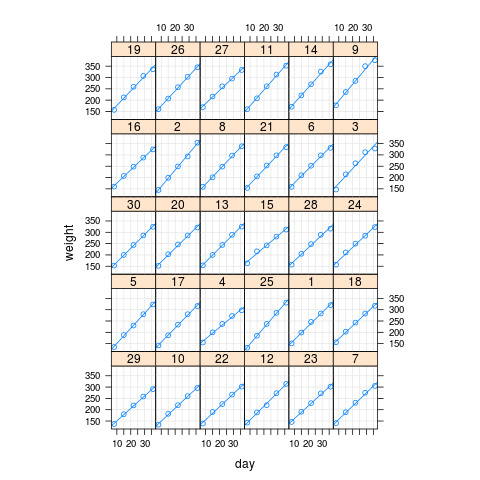

RCall.RObject{RCall.VecSxp}


In [20]:
"""
library(lattice)
print(xyplot(weight ~ day | reorder(id, weight), ratsL, type = c('p','g','r'), aspect = 'xy'))
""" |> reval

There is an overall linear trend in the weight with respect to time but there is also noticeable downward curvature for many of the rats.  Nevertheless we will start with a model with linear model with vector-valued random effects for slope and intercept by rat.

## Fitting the vector-valued random effects in lme4

The simplest way to write the model is `weight ~ 1 + day + (1 + day|id)` which allows for correlated random effects for slope and intercept for each rat.  We introduced the centered day, `dayc`, to help reduce the correlation of slope and intercept.  

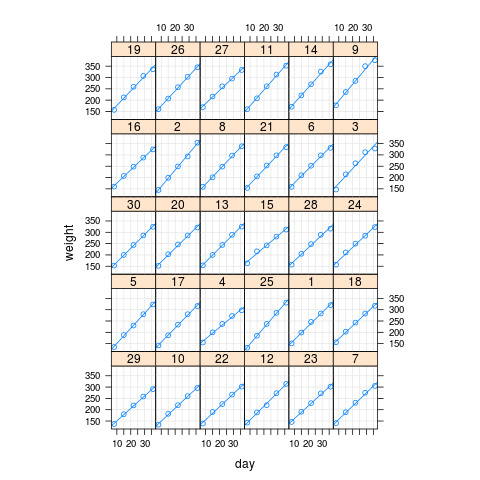

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: weight ~ 1 + dayc + (1 + dayc | id)
   Data: ratsL

     AIC      BIC   logLik deviance df.resid 
  1108.1   1126.1   -548.0   1096.1      144 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6317 -0.5422  0.1154  0.4948  2.6188 

Random effects:
 Groups   Name        Variance Std.Dev. Corr
 id       (Intercept) 196.1514 14.0054      
          dayc          0.2495  0.4995  0.67
 Residual              36.1756  6.0146      
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 242.6533     2.6038   93.19
dayc          6.1857     0.1038   59.58

Correlation of Fixed Effects:
     (Intr)
dayc 0.580 


In [21]:
"""
suppressPackageStartupMessages(library(lme4))
summary(m1 <- lmer(weight ~ 1 + dayc + (1 + dayc|id), ratsL, REML = FALSE))
""" |> reval

In [22]:
rcall(:ranef, :m1)

RCall.RObject{RCall.VecSxp}
$id
    (Intercept)        dayc
1   -2.82283510 -0.12578654
2    5.93882801  0.78307101
3    9.90346593  0.33371484
4  -10.74973914 -0.80488545
5  -10.45066792  0.23713689
6    6.94205684  0.04898216
7  -13.89050144 -0.29292648
8    5.86169511  0.24410478
9   40.76781136  1.07538481
10 -23.29905874 -0.48326724
11  15.90460290  0.65324080
12 -14.31379706 -0.17582145
13  -0.26200601 -0.02076169
14  25.63637011  0.64210429
15  -0.63963320 -0.65506352
16   2.33265934 -0.20317502
17 -10.18306118 -0.01121384
18  -2.47738392 -0.30851442
19  11.15063716  0.27921262
20  -1.13036416 -0.12086327
21   6.03986243  0.23631875
22 -17.42001157 -0.42464402
23 -14.31332271 -0.49138370
24   2.11000949 -0.23288776
25  -7.26660898  0.55158232
26  11.48449335  0.40267229
27  11.20695186 -0.14725729
28  -0.01664053 -0.28786181
29 -24.80200456 -0.64438296
30  -1.24180767 -0.05682908



We can check for non-negligible correlation of the random effects by fitting a model with uncorrelated random effects and comparing the fits.

In [25]:
"""
m2 <- lmer(weight ~ 1 + dayc + (1|id) + (0 + dayc|id), ratsL, REML = FALSE)
options(show.signif.stars = FALSE)
anova(m2, m1)
""" |> reval

RCall.RObject{RCall.VecSxp}
Data: ratsL
Models:
m2: weight ~ 1 + dayc + (1 | id) + (0 + dayc | id)
m1: weight ~ 1 + dayc + (1 + dayc | id)
   Df    AIC    BIC  logLik deviance  Chisq Chi Df Pr(>Chisq)
m2  5 1118.3 1133.4 -554.17   1108.3                         
m1  6 1108.1 1126.1 -548.03   1096.1 12.276      1  0.0004587


In [26]:
rcall(:summary, :m2)

RCall.RObject{RCall.VecSxp}
Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: weight ~ 1 + dayc + (1 | id) + (0 + dayc | id)
   Data: ratsL

     AIC      BIC   logLik deviance df.resid 
  1118.3   1133.4   -554.2   1108.3      145 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.52819 -0.64699  0.07742  0.48621  2.87684 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 196.1513 14.0054 
 id.1     dayc          0.2495  0.4995 
 Residual              36.1756  6.0146 
Number of obs: 150, groups:  id, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept) 242.6533     2.6038   93.19
dayc          6.1857     0.1038   59.58

Correlation of Fixed Effects:
     (Intr)
dayc 0.000 


## Fitting the same models with lmm in Julia

First we copy the data frames `rats` and `ratsL` from R to Julia then fit the models

In [27]:
@rget rats
@rget ratsL
using DataFrames, Mamba, MixedModels
m1 = fit!(lmm(weight ~ 1 + dayc + (1 + dayc|id), ratsL))

Linear mixed model fit by maximum likelihood
 logLik: -548.028661, deviance: 1096.057323, AIC: 1108.057323, BIC: 1126.121134

Variance components:
            Variance    Std.Dev.    Corr.
 id       196.1503971 14.00537030
            0.2495191  0.49951886  0.67
 Residual  36.1755955  6.01461515
 Number of obs: 150; levels of grouping factors: 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   242.653   2.60375 93.1938
dayc          6.18571  0.103818 59.5822


The two mixed-models packages agree on the fit.  The amount of time required for the lmm fit is

In [28]:
@time fit!(lmm(weight ~ 1 + dayc + (1 + dayc|id), ratsL));

  0.058935 seconds (85.45 k allocations: 3.346 MB)


In [29]:
@time m2 = fit!(lmm(weight ~ 1 + dayc + (1|id) + (0 + dayc|id), ratsL))

Linear mixed model fit by maximum likelihood
 logLik: -554.166872, deviance: 1108.333745, AIC: 1118.333745, BIC: 1133.386921

Variance components:
            Variance    Std.Dev.  
 id       196.15117421 14.0053980
 id         0.24952073  0.4995205
 Residual  36.17551676  6.0146086
 Number of obs: 150; levels of grouping factors: 30, 30

  Fixed-effects parameters:
             Estimate Std.Error z value
(Intercept)   242.653   2.60376 93.1936
dayc          6.18571  0.103818  59.582


0.060960 seconds (53.03 k allocations: 1.787 MB)


In [31]:
MixedModels.lrt(m2, m1)  # print format is still a bit primitive

,Df,Deviance,Chisq,pval
1,5,1108.3337448564334,NaN,NaN
2,6,1096.0573227024272,12.27642215400624,0.0004587169574480369


## A Mamba MCMC analysis of the independent random effects model

[Brian Smith](http://www.public-health.uiowa.edu/people/brian-smith/), the principal author of the [Mamba package](https://github.com/brian-j=smith/Mamba.jl) provides a BUGS-like approach to this model in the [Mamba documentation](http://mambajl.readthedocs.org/en/latest/examples/rats.html) which we will adapt here.  First we need to convert the data in the `ratsL` DataFrame, which are stored as `DataArray` types, to vectors.  These are stored in a dictionary with keys that are symbols.  This is similar to an R list except that there is no inherent ordering of the elements.  You can retrieve values by name (symbol) but not by index number.

In [34]:
ratsD = Dict{Symbol,Any}(
    :weight => convert(Vector{Float64}, ratsL[:weight]),
    :day => convert(Vector{Float64}, ratsL[:day]),
    :dayc => convert(Vector, ratsL[:dayc]),
    :id => convert(Vector{Int}, ratsL[:id]));
ratsD[:N] = length(unique(ratsD[:id]));
ratsD[:T] = length(unique(ratsD[:day]));
ratsD

Dict{Symbol,Any} with 6 entries:
  :weight => [151.0,145.0,147.0,155.0,135.0,159.0,141.0,159.0,177.0,134.0  …  3…
  :T      => 5
  :N      => 30
  :id     => [1,2,3,4,5,6,7,8,9,10  …  21,22,23,24,25,26,27,28,29,30]
  :day    => [8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0  …  36.0,36.0,36.0,36.0,3…
  :dayc   => [-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0,-14.0  …  1…

In [36]:
model = Model(

y = Stochastic(1,
    function(α, β, dayc, id, σ²)
        μ = α[id] + β[id] .* daysc
        MvNormal(μ, sqrt(σ²))
    end,
    false
),

α = Stochastic(1,
    (μα, σ²α) -> Normal(μα, sqrt(σ²α)),
    false
),

α0 = Logical((μα, xbar, μβ) -> μα - xbar * μβ),

μα = Stochastic(() -> Normal(0.0, 1000), false),

σ²α = Stochastic(() -> InverseGamma(0.001, 0.001), false),

β = Stochastic(1, (μβ, σ²β) -> Normal(μβ, sqrt(σ²β)), false),

μβ = Stochastic(() -> Normal(0.0, 1000)),

σ²β= Stochastic(() -> InverseGamma(0.001, 0.001), false),

σ² = Stochastic(() -> InverseGamma(0.001, 0.001))

)



Object of type "Mamba.Model"
-------------------------------------------------------------------------------
y:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
μβ:
A monitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
σ²α:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
μα:
An unmonitored node of type "Mamba.ScalarStochastic"
NaN
-------------------------------------------------------------------------------
α0:
A monitored node of type "Mamba.ScalarLogical"
NaN
-------------------------------------------------------------------------------
α:
An unmonitored node of type "0-element Mamba.ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
σ²β:
An unmonitored